## Long Term Stock Price growth prediction using NLP on 10K Financial Reports

## Problem Statement
* A 10-K FInancial Report is a comprehensive report which must be filed annually by all publicly traded companies about its financial performance. These reports are filed to the US Securities Exchange Commission (SEC). This is even more detailed than the annual report of a company. The 10K documents contain information about the Business' operations, risk factors, selected financial data, the Management's discussion and analysis (MD&A) and also Financial Statements and supplementary data. 10-K reports are very important for investors and Warren Buffet consistently cites these reports as a great source of information about a company's potential to succeed.
* We are expected to build an NLP pipeline that ingests 10-K reports of various publicly traded companies and build a machine learning model which can uncover the hidden signals to predict the long term stock performance of a company from the 10-K docs.

### Flow of the Module

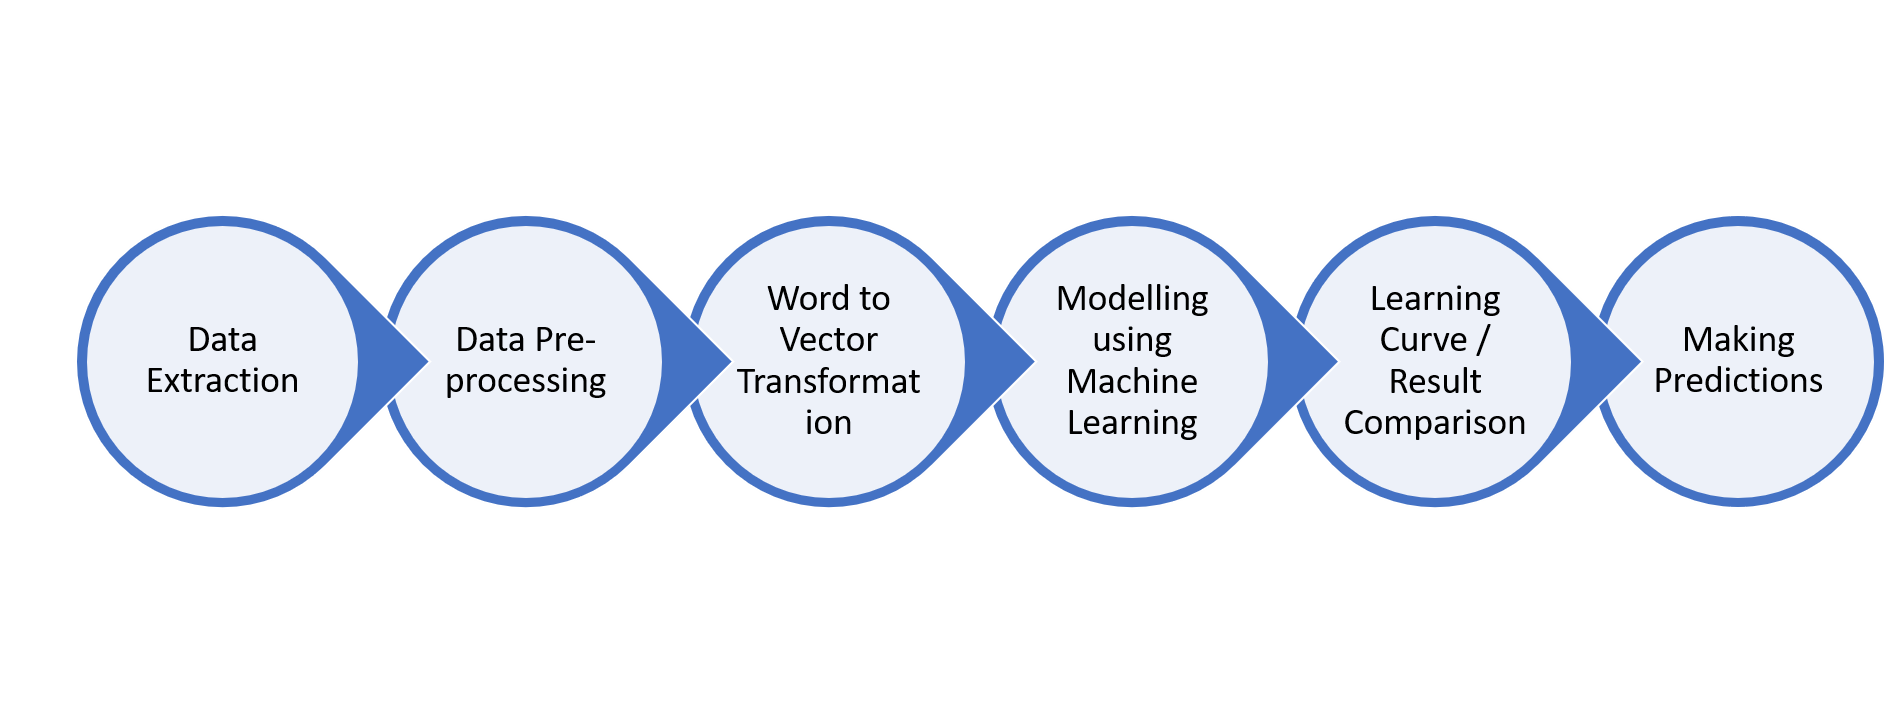

In [1]:
from IPython.display import Image
Image("process.png")

### Importing all required modules

In [3]:
import pandas as pd
import numpy as np
from datetime import date
import datetime 
from dateutil.relativedelta import relativedelta
import urllib.request as url 
from bs4 import BeautifulSoup as bs
import requests
import lxml.html as lh
import urllib
import time
import csv
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
from ast import literal_eval
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, recall_score, precision_score

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords as sw
from nltk.corpus import RegexpTokenizer as regextoken
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import seaborn as sns
nltk.download('punkt')
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore")
import re
%matplotlib inline

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


## Reading 10_k train data

In [5]:
data =pd.read_csv('10k_filing_info_train_links-1570100710859.csv')

In [6]:
data.head()

,ticker,cik,filing_date,10k_link,long_term_outlook
0,FE,1031296,2012-02-28,https://www.sec.gov/Archives/edgar/data/103129...,0
1,CL,21665,2015-02-19,https://www.sec.gov/Archives/edgar/data/21665/...,0
2,PRU,1137774,2016-02-19,https://www.sec.gov/Archives/edgar/data/113777...,1
3,EBAY,1065088,2001-03-28,https://www.sec.gov/Archives/edgar/data/106508...,1
4,CAM,941548,2005-02-25,https://www.sec.gov/Archives/edgar/data/941548...,1


In [7]:
data.describe(include='all')

,ticker,cik,filing_date,10k_link,long_term_outlook
count,2568,2.568000e+03,2568,2568,2568.000000
unique,193,NaN,943,2568,NaN
top,TMK,NaN,2010-02-26,https://www.sec.gov/Archives/edgar/data/109072...,NaN
freq,23,NaN,33,1,NaN
mean,NaN,5.422306e+05,NaN,NaN,0.709112
std,NaN,4.642214e+05,NaN,NaN,0.454260
min,NaN,4.281000e+03,NaN,NaN,0.000000
25%,NaN,6.949900e+04,NaN,NaN,0.000000
50%,NaN,7.136760e+05,NaN,NaN,1.000000
75%,NaN,9.061070e+05,NaN,NaN,1.000000


In [8]:
data.isna().sum()

ticker               0
cik                  0
filing_date          0
10k_link             0
long_term_outlook    0
dtype: int64

In [9]:
data.dtypes

ticker               object
cik                   int64
filing_date          object
10k_link             object
long_term_outlook     int64
dtype: object

### Webscrapping data and fetch only 10k document text data 

In [10]:
# Run this chunk code to webscrap data from SEC 

data =pd.read_csv('10k_filing_info_train_links-1570100710859.csv')
url_notavl=[]
df2 = []

# iterrate through data frame and read data of each row and pass it to new dictionary
for index, row in data.iterrows():
    # fetching each row data from 10k document and assigning to variable 
    cik=row['cik']
    ticker=row['ticker']
    filing_date=row['filing_date']
    ten_k_link = row['10k_link']
    long_term_outlook=row['long_term_outlook']
   
    try:
        # create dictionary to create new dataframe
        data_dict=dict()
        data_dict['cik'] = cik
        data_dict['ticker'] = ticker
        data_dict['filing_date'] = filing_date
        data_dict['10k_link'] = ten_k_link
        data_dict['long_term_outlook'] = long_term_outlook
        # scarpping data from sec website using beautiful soup and request package
        res = requests.get(row['10k_link'])
        html_page = bs(res.content,'html.parser')
        # fetching only 10k html data from SEC website
        html_page_10k=html_page.find_all('document')[0]
        html_regex = re.compile(r'<.*?>')
        paragraphs = []
        html_page_10 = html_page_10k.find_all(text=True)
        # converting ascii character to characters
        html_page_10 = u" ".join(t.strip() for t in html_page_10)
        html_page_10 = html_page_10.encode('ascii', 'ignore').decode('ascii')
        html_page_10=str(html_page_10)
        # removing all unwanted characters from 10k data
        html_page_10 = re.sub(html_regex,'',html_page_10)
        html_page_10 = html_page_10.replace('&nbsp;,','')
        html_page_10 = re.sub(r'&#\d+;\'"', '', html_page_10)
        html_page_10 = re.sub('\xa0', ' ', html_page_10)
        html_page_10 = re.sub('\\\\n', ' ', html_page_10)
        html_page_10 = re.sub('\\\\t', ' ', html_page_10)
        html_page_10 = re.sub('\%', ' ', html_page_10)
        html_page_10 = re.sub('\$', ' ', html_page_10)
        html_page_10 = re.sub(r"\b[a-zA-Z]\b", "", html_page_10)
        html_page_10 = re.sub('\s+', ' ', html_page_10)
        data_dict['10k_data']=html_page_10
        df2.append(data_dict)
        
    except:
        url_notavl.append(row['10k_link'])
        pass
      
# Creating Data frame and writing to csv
df = pd.DataFrame(df2) 
df.to_csv('training.csv')
df_not = pd.DataFrame(url_notavl) 
df_not.to_csv('Url_not_availale.csv')

### 10k_data column has all scrapped 10k document data 

In [11]:
data_train = pd.read_csv('training.csv')
data_train.head()

,Unnamed: 0,10k_data,10k_link,cik,filing_date,long_term_outlook,ticker
0,0,10-K 1 fe-12312011x10k.htm 10-K html PUBLIC ...,https://www.sec.gov/Archives/edgar/data/103129...,1031296,2012-02-28,0,FE
1,1,10-K 1 cl-12312014x10k.htm COLGATE-PALMOLIVE ...,https://www.sec.gov/Archives/edgar/data/21665/...,21665,2015-02-19,0,CL
2,2,"10-K 1 pfi201510-k.htm 10-K html PUBLIC ""-//...",https://www.sec.gov/Archives/edgar/data/113777...,1137774,2016-02-19,1,PRU
3,3,10-K 1 f70837e10-k.txt FORM 10-K FISCAL YEAR ...,https://www.sec.gov/Archives/edgar/data/106508...,1065088,2001-03-28,1,EBAY
4,4,10-K 1 h21764e10vk.htm COOPER CAMERON CORP.- ...,https://www.sec.gov/Archives/edgar/data/941548...,941548,2005-02-25,1,CAM


In [12]:
data_train['filing_date']=pd.to_datetime(data_train['filing_date'])

In [13]:
# From extracted data fetch number of years of data, just change number to fetch only required amount of data
nu_years_date = date.today() + relativedelta(years=-22)
nu_years_date=pd.to_datetime(nu_years_date)

In [14]:
required_years_data =data_train[data_train['filing_date']>=nu_years_date]


In [16]:
type(required_years_data)

pandas.core.frame.DataFrame

### Cleaning Scrapped data

In [17]:
# This function will clean data and get clean output
def clean_data(row_train):
   #Replace \xao characters in text
    
    row_train = re.sub('\xa0', ' ', row_train)
    row_train = re.sub('\\\\n', ' ', row_train)
    row_train = re.sub('\\\\t', ' ', row_train)
    row_train = re.sub('\%', ' ', row_train)
    row_train = re.sub('\$', ' ', row_train)
    row_train = re.sub('\&', ' ', row_train)
    row_train = re.sub('nbsp;', ' ', row_train)
    row_train = re.sub('\\d', ' ', row_train)
    row_train = re.sub(r"[^a-zA-Z0-9]+", ' ', row_train)

    row_train = re.sub(r"\b[a-zA-Z]\b", "", row_train)
    row_train = re.sub('\s+', ' ', row_train)

    return row_train

In [19]:
#required_years_data['clean_10k_data'] =required_years_data['10k_data'].apply(clean_data)

### Performing tokenisation , lemmatization , and removing stopwords

In [19]:
# Function to pick lemmatize part of speach
def get_wordnet_pos(word):
  
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wn.ADJ,
                "N": wn.NOUN,
                "V": wn.VERB,
                "R": wn.ADV}

    return tag_dict.get(tag, wn.VERB)

In [20]:
# function to tokenise data , lemmatize word and remove stop word

import nltk
from nltk.corpus import stopwords
from nltk.corpus import RegexpTokenizer as regextoken
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
customize_stop_words =('en', 'http', 'www', 'org', 'tr','rsg', 'xk', 'htm', 'html', 'public', 'dtd','lh','td','zip', 'code','inc','area', 'code','telephone', 'number','th', 'iii', 'form', 'table', 'content', 'pnc')
stop_words.update(customize_stop_words)

def remove_stopwords(*args):
    
    filtered_tokens=[]
    # iterate list of arguments and add all data and process it  
    for elem in args:
        elem =str(elem)
        element +=elem
    result=element.lower()
    #sent_tokens = sent_tokenize(result)
    # Tokenise the word
    word_tokens = word_tokenize(result)
    
    wordnet_lemmatizer = WordNetLemmatizer()
    # remove stop words
    filtered_words = [w for w in word_tokens if not w in stop_words] 
    
    # lemmatization of each word
    for lematised in filtered_words:
        word_lem = wordnet_lemmatizer.lemmatize(lematised,  get_wordnet_pos(lematised))
        filtered_tokens.append(word_lem)
    
    # converting it to string to pass it to data frame
    filtered_tokens= str(filtered_tokens)
   
    
    return filtered_tokens

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [19]:

#required_years_data['tokenized_data'] =required_years_data.clean_10k_data.apply(remove_stopwords_one)


In [20]:
required_years_data.head()

,Unnamed: 0,10k_data,10k_link,cik,filing_date,long_term_outlook,ticker
0,0,10-K 1 fe-12312011x10k.htm 10-K html PUBLIC ...,https://www.sec.gov/Archives/edgar/data/103129...,1031296,2012-02-28,0,FE
1,1,10-K 1 cl-12312014x10k.htm COLGATE-PALMOLIVE ...,https://www.sec.gov/Archives/edgar/data/21665/...,21665,2015-02-19,0,CL
2,2,"10-K 1 pfi201510-k.htm 10-K html PUBLIC ""-//...",https://www.sec.gov/Archives/edgar/data/113777...,1137774,2016-02-19,1,PRU
3,3,10-K 1 f70837e10-k.txt FORM 10-K FISCAL YEAR ...,https://www.sec.gov/Archives/edgar/data/106508...,1065088,2001-03-28,1,EBAY
4,4,10-K 1 h21764e10vk.htm COOPER CAMERON CORP.- ...,https://www.sec.gov/Archives/edgar/data/941548...,941548,2005-02-25,1,CAM


In [21]:
required_years_data['long_term_outlook'] = required_years_data['long_term_outlook'].astype('category')

### This code will fetch all all reqired data

#### From 10k Document will have got important features like Management Discussion And Analysis ,Quantative AND Qualitative, Risk factor, Business Selected Financial Data
* Business. This provides an overview of the company’s main operations, including its products and services (i.e., how it makes money).
* Risk factors. These outline any and all risks the company faces or may face in the future. The risks are typically listed in order of importance.
* Selected financial data. This section details specific financial information about the company over the last five years. This section presents more of a near-term view of the company’s recent performance.
* Management’s discussion and analysis of financial condition and results of operations. Also known as MD&A, this gives the company an opportunity to explain its business results from the previous fiscal year. This section is where the company can tell its story in its own words.
* Financial statements and supplementary data. This includes the company’s audited financial statements including the income statement, balance sheets, and statement of cash flows. A letter from the company’s independent auditor certifying the scope of their review is also included in this section

In [22]:
# This function will to fetch data and create feature set of 
# Management Discussion And Analysis ,Quantative AND Qualitative, Risk factor, Business Selected Financial Data

def read_url(required_years_data):
    dat_extract=[]
    for index, row_train in required_years_data.iterrows():
        data_result = dict()

        row_train =row_train['10k_data']
        # Regex to fetch data from 10k document
        mda_regex = r"ITEM[a-zA-Z\n\s]*\d[a-zA-Z\n\s]*\.\s*MANAGEMENTS* DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS(.+?)ITEM[a-zA-Z\n\s]*\d[a-zA-Z\n\s]*\.\s*"
        quantative_regex=r"ITEM[a-zA-Z\n\s]*\d[a-zA-Z\n\s]*\.\s*QUANTITATIVE AND QUALITATIVE DISCLOSURES ABOUT MARKET RISK(.+?)ITEM[a-zA-Z\n\s]*\d[a-zA-Z\n\s]*\.\s*"
        risk_regex =r"ITEM[a-zA-Z\n\s]*\d[a-zA-Z\n\s]*\.\s*RISK FACTORS(.+?)ITEM[a-zA-Z\n\s]*\d[a-zA-Z\n\s]*\.\s*"
        business_regex=r"ITEM[a-zA-Z\n\s]*\d[a-zA-Z\n\s]*\.\s*Business(.+?)ITEM[a-zA-Z\n\s]*\d[a-zA-Z\n\s]*\.\s*"
        selected_financial_data_regex=r"ITEM[a-zA-Z\n\s]*\d[a-zA-Z\n\s]*\.\s*Selected Financial Data(.+?)ITEM[a-zA-Z\n\s]*\d[a-zA-Z\n\s]*\.\s*"
        financial_statements_supplementary_data_regex=r"ITEM[a-zA-Z\n\s]*\d[a-zA-Z\n\s]*\.\s*Financial Statements and Supplementary Data(.+?)ITEM[a-zA-Z\n\s]*\d[a-zA-Z\n\s]*\.\s*"
        
        matches_quantative= re.findall(quantative_regex, row_train, re.IGNORECASE | re.DOTALL | re.MULTILINE)
        matches_risk= re.findall(risk_regex, row_train, re.IGNORECASE | re.DOTALL | re.MULTILINE)
        matches_business= re.findall(business_regex, row_train, re.IGNORECASE | re.DOTALL | re.MULTILINE)
        matches_selected_financial_data= re.findall(selected_financial_data_regex, row_train, re.IGNORECASE | re.DOTALL | re.MULTILINE)
        matches_financial_statements=re.findall(financial_statements_supplementary_data_regex, row_train, re.IGNORECASE | re.DOTALL | re.MULTILINE)
        matches_mda = re.findall(mda_regex, row_train, re.IGNORECASE | re.DOTALL | re.MULTILINE)

        if matches_mda:
            resultmda = max(matches_mda, key=len)
            resultmda = str(resultmda).replace('\n', '')
            resultmda=clean_data(resultmda)
            data_result['result_mda']=resultmda
        elif 'nan':
            data_result['result_mda']=''
            

        if matches_financial_statements:
            resultfinancial = max(matches_financial_statements, key=len)
            resultfinancial = str(resultfinancial).replace('\n', '')
            resultfinancial=clean_data(resultfinancial)
            data_result['result_financial']=resultfinancial
        elif 'nan':
            data_result['result_financial']=''

        if matches_selected_financial_data:
            resultselectedfinancial = max(matches_selected_financial_data, key=len)
            resultselectedfinancial = str(resultselectedfinancial).replace('\n', '')
            resultselectedfinancial=clean_data(resultselectedfinancial)
            data_result['result_selectedfinancial']=resultselectedfinancial
        elif 'nan':
            data_result['result_selectedfinancial']=''

        if matches_business:
            resultbusiness = max(matches_business, key=len)
            resultbusiness = str(resultbusiness).replace('\n', '')
            resultbusiness=clean_data(resultbusiness)
            data_result['result_business']=resultbusiness
        elif 'nan' or 'NaN':
            data_result['result_business']=''

        if matches_risk:
            resultrisk = max(matches_risk, key=len)
            resultrisk = str(resultrisk).replace('\n', '')
            resultrisk=clean_data(resultrisk)
            data_result['resul_trisk']=resultrisk
        elif 'nan':
            data_result['resul_trisk']=''

        if matches_quantative:
            resultquantative = max(matches_quantative, key=len)
            resultquantative = str(resultquantative).replace('\n', '')
            resultquantative=clean_data(resultquantative)
            data_result['result_quantative']=resultquantative
        elif 'nan':
            data_result['result_quantative']=''
        dat_extract.append(data_result)
    return dat_extract

In [23]:
#  All important feature data writing it to csv
required_years_data = pd.DataFrame(read_url(required_years_data)) 
required_years_data.to_csv('train_extract_data_10k.csv')


In [24]:
# Calling function to  remove stop words after fetching important features
required_years_data['tokenized_data'] =np.vectorize(remove_stopwords)(required_years_data['result_mda'],required_years_data['result_financial'],required_years_data['result_selectedfinancial'],train_extract_data_10k['result_business'],required_years_data['resul_trisk'],required_years_data['result_quantative'])

### Reading finanace dictionary and fetching all Negative , Positive , Uncertainty, Litigious,Constraining,Superfluous ,Interesting ,Modal ,Irr_Verb ,Harvard_IV ,Syllables

In [7]:
data_word_function = pd.read_csv('finance_word_dictionary-1570171303593.csv')

In [8]:
# This chunk will fetch data which are not zero from finance_word_dictionary csv and create list of all features
Negative=[]
Positive=[]
Uncertainty=[]
Litigious=[]
Constraining=[]
Superfluous=[]
Interesting=[]
Modal=[]
Irr_Verb=[]
Harvard_IV=[]
Syllables=[]
for index_word , row_word in data_word_function.iterrows():
    if row_word['Negative'] != 0:
        Negative.append(row_word['Word'] )
    if row_word['Positive'] != 0:
        Positive.append(row_word['Word'] )
    if row_word['Uncertainty'] != 0:
        Uncertainty.append(row_word['Word'] )
    if row_word['Litigious'] != 0:
        Litigious.append(row_word['Word'] )
    if row_word['Constraining'] != 0:
        Constraining.append(row_word['Word'] )
    if row_word['Superfluous'] != 0:
        Superfluous.append(row_word['Word'] )
    if row_word['Interesting'] != 0:
        Interesting.append(row_word['Word'] )
    if row_word['Modal'] != 0:
        Modal.append(row_word['Word'] )
    if row_word['Irr_Verb'] != 0:
        Irr_Verb.append(row_word['Word'] )
    if row_word['Harvard_IV'] != 0:
        Harvard_IV.append(row_word['Word'] )
    if row_word['Syllables'] != 0:
        Syllables.append(row_word['Word'] )
        


### Mapping extracted data with finance_word_dictionary and adding columns to dataframe

In [31]:
# These functions compare word from above list from finance dictionary 
# create new column in data frame with count of positive, negative ,and etc 

def negative_word(text):
    text =literal_eval(text)
    numNegWords=0
    for word in text:
        if word.upper() in Negative:
            numNegWords +=1
    return numNegWords

def positive_word(text):
    text =literal_eval(text)
    numposWords=0
    for word in text:
        if word.upper() in Positive:
            numposWords +=1
    return numposWords

def uncertain_word(text):
    text =literal_eval(text)
    numuncWords=0
    for word in text:
        if word.upper() in Uncertainty:
            numuncWords +=1
    return numuncWords

def constraint_word(text):
    text =literal_eval(text)
    numconWords=0
    for word in text:
        if word.upper() in Constraining:
            numconWords +=1
    return numconWords

def litigious_word(text):
    text =literal_eval(text)
    numlinWords=0
    for word in text:
        if word.upper() in Litigious:
            numlinWords +=1
    return numlinWord

def superfluous_word(text):
    text =literal_eval(text)
    numsfnWords=0
    for word in text:
        if word.upper() in Superfluous:
            numsfnWords +=1
    return numsfnWords

def interesting_word(text):
    text =literal_eval(text)
    numinWords=0
    for word in text:
        if word.upper() in Interesting:
            numinWords +=1
    return numinWords

def modal_word(text):
    text =literal_eval(text)
    nummoWords=0
    for word in text:
        if word.upper() in Modal:
            nummoWords +=1
    return nummoWords

def word_count(text):
    text =literal_eval(text)
    count =len(text)
    return count

In [32]:
# calling all above funtions to create dataframe in required_years_data data set
required_years_data['negative']=required_years_data.tokenized_data.apply(negative_word)
required_years_data['positive']=required_years_data.tokenized_data.apply(positive_word)
required_years_data['uncertain']=required_years_data.tokenized_data.apply(uncertain_word)
required_years_data['constraint']=required_years_data.tokenized_data.apply(constraint_word)
required_years_data['litigious']=required_years_data.tokenized_data.apply(litigious_word)
required_years_data['superfluous']=required_years_data.tokenized_data.apply(superfluous_word)
required_years_data['interesting']=required_years_data.tokenized_data.apply(interesting_word)
required_years_data['modal']=required_years_data.tokenized_data.apply(modal_word)
required_years_data['word_count']=required_years_data.tokenized_data.apply(word_count)


### Above All function are executed in test data and create test_extract_test_data_10k csv 

In [34]:
# reading test data for further analysis
data_test =pd.read_csv('test_extract_test_data_10k.csv')

In [35]:
data_test['negative']=data_test.tokenized_data.apply(negative_word)
data_test['positive']=data_test.tokenized_data.apply(positive_word)
data_test['uncertain']=data_test.tokenized_data.apply(uncertain_word)
data_test['constraint']=data_test.tokenized_data.apply(constraint_word)
data_test['litigious']=data_test.tokenized_data.apply(litigious_word)
data_test['superfluous']=data_test.tokenized_data.apply(superfluous_word)
data_test['interesting']=data_test.tokenized_data.apply(interesting_word)
data_test['modal']=data_test.tokenized_data.apply(modal_word)
data_test['word_count']=data_test.tokenized_data.apply(word_count)



In [36]:
required_years_data.to_csv('train_extract_data_10k',index=False)

In [37]:
data_test.to_csv('test_extract_test_data_10k.csv',index=False)

In [38]:
test_extract_test_data_10k =pd.read_csv('test_extract_test_data_10k.csv')


In [39]:
train_extract_data_10k =pd.read_csv('train_extract_data_10k.csv')

# Visualisation of data using Word Cloud

In [40]:
# To generate word cloud compare each word with finance dictionary list and create string data

def get_All_data(text):
    text = literal_eval(text)
    text_data =" ".join(text)
        
    return text_data

def positive_word(text):
    text =literal_eval(text)
    eleword = []
    for word in text:
        if word.upper() in Positive:
            eleword.append(word)
    posword =" ".join(eleword)
        
    return posword

def negative_word(text):
    text =literal_eval(text)
    elewordn = []
    for word in text:
        if word.upper() in Negative:
            elewordn.append(word)
    negword =" ".join(elewordn)
        
    return negword

In [41]:
train =train_extract_data_10k.tokenized_data.apply(get_All_data)

In [42]:
positive =train_extract_data_10k.tokenized_data.apply(positive_word)

In [43]:
negative =train_extract_data_10k.tokenized_data.apply(negative_word)

In [44]:
# Getting frequency of word to generate word cloud
def most_occured(data):
    #global Counter
    check =data.str.cat(sep=', ')
    split_it = check.split() 
    counter = Counter(split_it)
    most_occur = counter.most_common(150) 
    most_occur =[x for x,_ in most_occur]
    most_occur =" ".join(most_occur)

    return most_occur

### All data word cloud

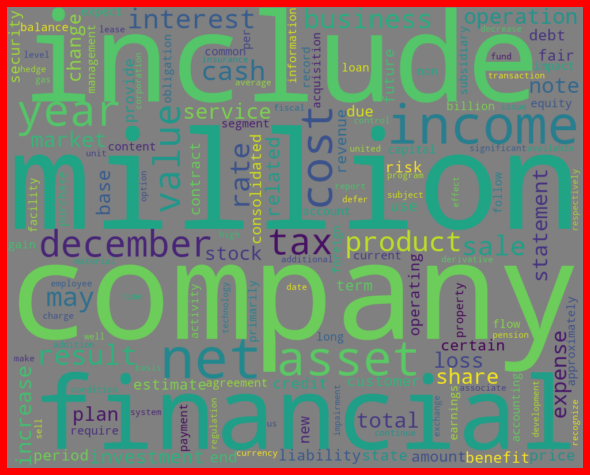

In [26]:
# Plot word cloud most freaquent word
wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='grey', 
                
                min_font_size = 10).generate(most_occured(train)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = 'red',) 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### Positive data using word cloud

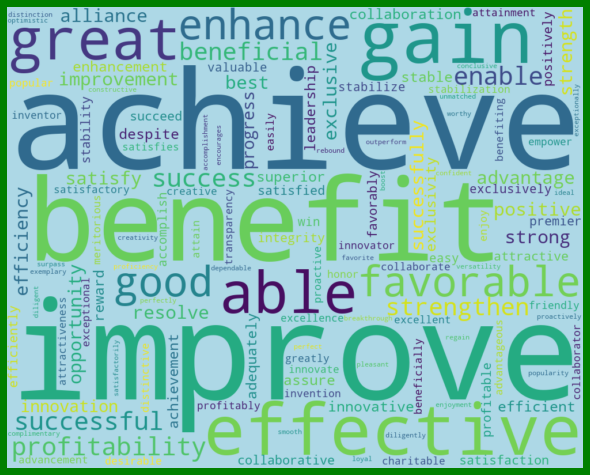

In [24]:
# Plot word cloud most freaquent positiveword
wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='lightblue', 
                
                min_font_size = 10).generate(most_occured(positive)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = 'green',) 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### Negative data using word cloud

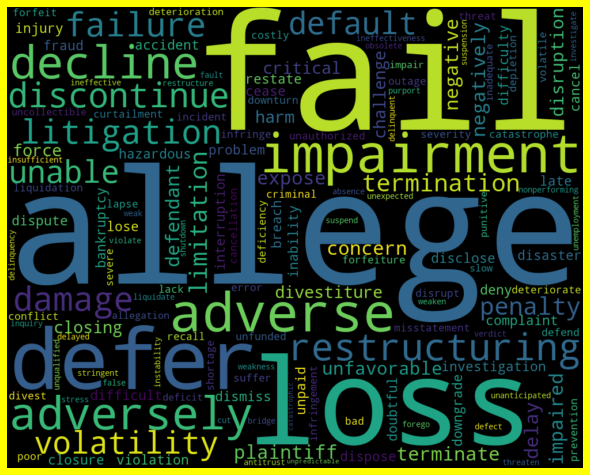

In [28]:

# Plot word cloud most freaquent positiveword
wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='black', 
                
                min_font_size = 10).generate(most_occured(negative)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = 'yellow',) 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [40]:
# Function to calculating Percentage of all important features
def calculate(numerator,denomenator):
    if denomenator != 0:
        percentage = numerator/denomenator
    else:
        percentage = denomenator
    return percentage

In [41]:
# calling above function to calulate percentage for train data set
train_extract_data_10k['neg_per']=np.vectorize(calculate)(train_extract_data_10k['negative'],train_extract_data_10k['word_count'])
train_extract_data_10k['pos_per']=np.vectorize(calculate)(train_extract_data_10k['positive'],train_extract_data_10k['word_count'])
train_extract_data_10k['con_per']=np.vectorize(calculate)(train_extract_data_10k['constraint'],train_extract_data_10k['word_count'])
train_extract_data_10k['li_per']=np.vectorize(calculate)(train_extract_data_10k['litigious'],train_extract_data_10k['word_count'])
train_extract_data_10k['super_per']=np.vectorize(calculate)(train_extract_data_10k['superfluous'],train_extract_data_10k['word_count'])
train_extract_data_10k['interest_per']=np.vectorize(calculate)(train_extract_data_10k['interesting'],train_extract_data_10k['word_count'])
train_extract_data_10k['modal_per']=np.vectorize(calculate)(train_extract_data_10k['modal'],train_extract_data_10k['word_count'])
train_extract_data_10k['uncertain_per']=np.vectorize(calculate)(train_extract_data_10k['uncertain'],train_extract_data_10k['word_count'])

In [42]:
# calling above function to calulate percentage for test data set
test_extract_test_data_10k['neg_per']=np.vectorize(calculate)(test_extract_test_data_10k['negative'],test_extract_test_data_10k['word_count'])
test_extract_test_data_10k['pos_per']=np.vectorize(calculate)(test_extract_test_data_10k['positive'],test_extract_test_data_10k['word_count'])
test_extract_test_data_10k['con_per']=np.vectorize(calculate)(test_extract_test_data_10k['constraint'],test_extract_test_data_10k['word_count'])
test_extract_test_data_10k['li_per']=np.vectorize(calculate)(test_extract_test_data_10k['litigious'],test_extract_test_data_10k['word_count'])
test_extract_test_data_10k['super_per']=np.vectorize(calculate)(test_extract_test_data_10k['superfluous'],test_extract_test_data_10k['word_count'])
test_extract_test_data_10k['interest_per']=np.vectorize(calculate)(test_extract_test_data_10k['interesting'],test_extract_test_data_10k['word_count'])
test_extract_test_data_10k['modal_per']=np.vectorize(calculate)(test_extract_test_data_10k['modal'],test_extract_test_data_10k['word_count'])
test_extract_test_data_10k['uncertain_per']=np.vectorize(calculate)(test_extract_test_data_10k['uncertain'],test_extract_test_data_10k['word_count'])

In [43]:
# calculating neutral words
def add(a,b,c,d,e,f,g,h):
    add  =h-(a+b+c+d+e+f+g)
    total =calculate(add,h)
    return total

In [44]:
test_extract_test_data_10k['calulated_neutral']=np.vectorize(add)(test_extract_test_data_10k['modal'],test_extract_test_data_10k['negative'],test_extract_test_data_10k['positive'],test_extract_test_data_10k['constraint'],test_extract_test_data_10k['litigious'],test_extract_test_data_10k['superfluous'],test_extract_test_data_10k['interesting'],test_extract_test_data_10k['word_count'])

In [45]:
train_extract_data_10k['calulated_neutral']=np.vectorize(add)(train_extract_data_10k['modal'],train_extract_data_10k['negative'],train_extract_data_10k['positive'],train_extract_data_10k['constraint'],train_extract_data_10k['litigious'],train_extract_data_10k['superfluous'],train_extract_data_10k['interesting'],train_extract_data_10k['word_count'])

In [46]:
test_extract_test_data_10k.to_csv('test_extract_test_data_10k.csv', index=False)
train_extract_data_10k.to_csv('train_extract_data_10k.csv', index=False)

In [47]:
train_extract_data_10k.head()

,10k_data,10k_link,cik,filing_date,long_term_outlook,ticker,Unnamed: 0.1.1.1.1,resul_trisk,result_business,result_financial,...,word_count,neg_per,pos_per,con_per,li_per,super_per,interest_per,modal_per,uncertain_per,calulated_neutral
0,10-K 1 fe-12312011x10k.htm 10-K html PUBLIC ...,https://www.sec.gov/Archives/edgar/data/103129...,1031296,2012-02-28,0,FE,0,for additional information regarding risks th...,The Company FirstEnergy Corp was organized un...,MANAGEMENT REPORTS Managements Responsibility...,...,41132,0.024336,0.012156,0.011038,0.021856,0.000097,0.002407,0.007342,0.016751,0.920767
1,10-K 1 cl-12312014x10k.htm COLGATE-PALMOLIVE ...,https://www.sec.gov/Archives/edgar/data/21665/...,21665,2015-02-19,0,CL,1,Set forth below is summary of the material ri...,General Development of the Business Colgate P...,See Index to Financial Statements,...,10660,0.027955,0.016510,0.008255,0.010882,0.000000,0.008349,0.012008,0.024390,0.916041
2,"10-K 1 pfi201510-k.htm 10-K html PUBLIC ""-//...",https://www.sec.gov/Archives/edgar/data/113777...,1137774,2016-02-19,1,PRU,2,You should carefully consider the following r...,Overview Prudential Financial Inc financial s...,CONSOLIDATED FINANCIAL STATEMENTS INDEX Page ...,...,110124,0.029276,0.018888,0.009998,0.020195,0.000182,0.003296,0.010942,0.025698,0.907223
3,10-K 1 f70837e10-k.txt FORM 10-K FISCAL YEAR ...,https://www.sec.gov/Archives/edgar/data/106508...,1065088,2001-03-28,1,EBAY,3,NaN,NaN,NaN,...,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,10-K 1 h21764e10vk.htm COOPER CAMERON CORP.- ...,https://www.sec.gov/Archives/edgar/data/941548...,941548,2005-02-25,1,CAM,4,NaN,Cooper Cameron Corporation Cooper Cameron or ...,Thefollowing consolidated financial statement...,...,170,0.000000,0.000000,0.000000,0.011765,0.000000,0.000000,0.000000,0.005882,0.988235


In [48]:
test_extract_test_data_10k.head()

,resul_trisk,result_business,result_financial,result_mda,result_quantative,result_selectedfinancial,tokenized_data,negative,positive,uncertain,...,word_count,neg_per,pos_per,con_per,li_per,super_per,interest_per,modal_per,uncertain_per,calulated_neutral
0,an investment in our common stock or debt sec...,business overview general dynamics is an aero...,consolidated statement of earnings year ended...,For an overview of our business groups includ...,we are exposed to market risk primarily from ...,the following table presents selected histori...,"['overview', 'business', 'group', 'include', '...",403,374,431,...,22411,0.017982,0.016688,0.009281,0.021686,0.000045,0.003748,0.008969,0.019232,0.921601
1,NaN,bank corporation registrant or is new york bu...,financial statements and supplementary data c...,NaN,incorporated by reference to the discussion c...,see cross reference sheet for disclosures inc...,"['nan', 'financial', 'statement', 'supplementa...",237,132,242,...,12678,0.018694,0.010412,0.009938,0.013330,0.000552,0.001104,0.009544,0.019088,0.936425
2,NaN,,,Capitalized terms herein are defined in the f...,,,"['capitalize', 'term', 'herein', 'define', 'fo...",75,37,43,...,2215,0.033860,0.016704,0.012190,0.008126,0.003160,0.015801,0.009481,0.019413,0.900677
3,risks associated with the companys business c...,laboratory corporation of america holdings an...,reference is made to the index on page of the...,in millions General During the Company contin...,,the selected financial data presented below u...,"['million', 'general', 'company', 'continued',...",471,239,325,...,14557,0.032356,0.016418,0.013396,0.024112,0.000069,0.002610,0.016143,0.022326,0.894896
4,NaN,overview sysco corporation acting through its...,sysco corporation and subsidiaries index to c...,NaN,sysco does not utilize financial instruments ...,fiscal year weeks in thousands except for sha...,"['nan', 'sysco', 'corporation', 'subsidiary', ...",119,90,148,...,8855,0.013439,0.010164,0.008809,0.006324,0.000000,0.002936,0.006324,0.016714,0.952005


In [36]:
train_data= train_extract_data_10k.loc[:,['neg_per','pos_per','con_per','li_per','super_per','interest_per','modal_per','uncertain_per','calulated_neutral']]

In [39]:
test_data=test_extract_test_data_10k.loc[:,['neg_per','pos_per','con_per','li_per','super_per','interest_per','modal_per','uncertain_per','calulated_neutral']]

In [40]:
train_data = pd.DataFrame(train_data)

In [41]:
test_data = pd.DataFrame(test_data)

In [46]:
train_data.head()

,neg_per,pos_per,con_per,li_per,super_per,interest_per,modal_per,uncertain_per,calulated_neutral
0,0.024336,0.012156,0.011038,0.021856,0.000097,0.002407,0.007342,0.016751,0.920767
1,0.027955,0.016510,0.008255,0.010882,0.000000,0.008349,0.012008,0.024390,0.916041
2,0.029276,0.018888,0.009998,0.020195,0.000182,0.003296,0.010942,0.025698,0.907223
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,0.000000,0.000000,0.000000,0.011765,0.000000,0.000000,0.000000,0.005882,0.988235


In [43]:
train_data.dtypes

neg_per              float64
pos_per              float64
con_per              float64
li_per               float64
super_per            float64
interest_per         float64
modal_per            float64
uncertain_per        float64
calulated_neutral    float64
dtype: object

In [44]:
test_data.dtypes

neg_per              float64
pos_per              float64
con_per              float64
li_per               float64
super_per            float64
interest_per         float64
modal_per            float64
uncertain_per        float64
calulated_neutral    float64
dtype: object

In [54]:
test_data.head()

,neg_per,pos_per,con_per,li_per,super_per,interest_per,modal_per,uncertain_per,calulated_neutral
0,0.017982,0.016688,0.009281,0.021686,0.000045,0.003748,0.008969,0.019232,0.921601
1,0.018694,0.010412,0.009938,0.013330,0.000552,0.001104,0.009544,0.019088,0.936425
2,0.033860,0.016704,0.012190,0.008126,0.003160,0.015801,0.009481,0.019413,0.900677
3,0.032356,0.016418,0.013396,0.024112,0.000069,0.002610,0.016143,0.022326,0.894896
4,0.013439,0.010164,0.008809,0.006324,0.000000,0.002936,0.006324,0.016714,0.952005


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


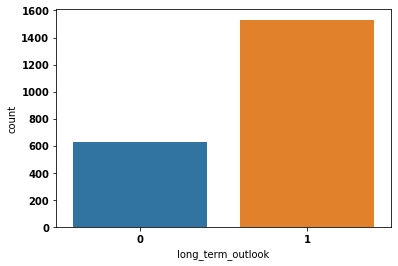

In [53]:
sns.countplot(x=train_extract_data_10k['long_term_outlook'], data= train_data)
plt.show()


In [64]:
train_X, test_X, train_y, test_y = train_test_split(train_data,train_extract_data_10k['long_term_outlook'],test_size=0.2,random_state=123)

In [65]:
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(1729, 9)
(433, 9)
(1729,)
(433,)


In [57]:
stop_words = sw.words('english')
stop_words.extend(['htm','year','form','report','dtd', 'txt', 'html', 'fiscal', 'united', 'states',
                   'exchange','commission',  'ti', 'reference', 'annual', 'aa', 'aaa', 'aaaa', 'ab',
                   'nan','','abb', 'zero', 'zonal','zz', 'zzz', 'zy', 'zoos', 'zone', 'zip', 'abc', 
                   'yy','yyy', 'york', 'nannannan', 'nannan','nannannan', 'nan','con', 'edison', 'con',
                   'edison', 'new', 'york', 'con', 'edison', 'con', 'edison', 'new', 'york', 'con', 
                   'edison', 'con', 'edison', 'new', 'york','con', 'edison', 'v','con', 'edison', 'new',
                   'york', 'con', 'edison', 'con', 'edison','nannannannannannan',' ','[',']'])



Tfidf_vect = TfidfVectorizer(stop_words=stop_words, max_features=10000)
Tfidf_vect.fit(train_X)
train_X_Tfidf = Tfidf_vect.transform(train_X)
test_X_Tfidf = Tfidf_vect.transform(test_X)

# Randon Forest


In [66]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# Use a grid over parameters of interest
## n_estimators is the number of trees in the forest
## max_depth is how deep each tree can be
## min_sample_leaf is the minimum samples required in each leaf node for the root node to split
## "A node will only be split if in each of it's leaf nodes there should be min_sample_leaf"
rfc_grid_2 = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample')
param_grid = {"n_estimators" : [15, 30, 45,50],
           "max_depth" : [None,2,5,10],
           "min_samples_leaf" : [5, 10,15],
              "class_weight" : ['balanced','balanced_subsample']}
 
rfc_cv_grid = RandomizedSearchCV(estimator = rfc_grid_2, param_distributions = param_grid, cv = 4, n_iter = 5)



rfc_cv_grid =rfc_cv_grid.fit(train_X, train_y)
train_pred_rf = rfc_cv_grid.predict(train_X)
test_pred_rf = rfc_cv_grid.predict(test_X)
print(classification_report(train_y,train_pred_rf))
print(classification_report(test_y,test_pred_rf))
prediction_test_rf = rfc_cv_grid.predict(test_data)
print(prediction_test_rf)

              precision    recall  f1-score   support

           0       0.60      0.83      0.70       500
           1       0.92      0.78      0.84      1229

    accuracy                           0.79      1729
   macro avg       0.76      0.80      0.77      1729
weighted avg       0.83      0.79      0.80      1729

              precision    recall  f1-score   support

           0       0.37      0.38      0.38       131
           1       0.73      0.72      0.73       302

    accuracy                           0.62       433
   macro avg       0.55      0.55      0.55       433
weighted avg       0.62      0.62      0.62       433

[1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 0
 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1
 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1

No handles with labels found to put in legend.


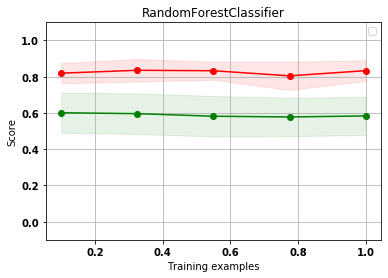

In [95]:

predict=rfc_cv_grid
train_sizes =np.linspace(.1, 1.0, 5)
cv =10
n_jobs=-1
verbose=0
classifier ='RandomForestClassifier'

plot = learning(predict, train_X, train_y,n_jobs, cv, train_sizes,verbose,classifier)

In [94]:
def learning(predict, train_X, train_y, n_jobs, cv, train_sizes, verbose,classifier):
    learning_curve(predict, train_X, train_y, n_jobs=n_jobs, cv=cv, train_sizes=train_sizes, verbose=verbose)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(classifier)
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()

    # box-like grid
    plt.grid()

    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(-.1,1.1)
    return plt.show()

In [61]:
prediction_test_rf = pd.DataFrame(prediction_test_rf)
prediction_test_rf.to_csv('random_forest_model2.csv')

# Model 2 Random Forest

In [97]:

rfc_grid_2 = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample')
param_grid = {"n_estimators" : [15, 30],
           "max_depth" : [None,2,5],
           "min_samples_leaf" : [5, 10],
            
              "class_weight" : ['balanced','balanced_subsample']}
 
rfc_cv_grid = RandomizedSearchCV(estimator = rfc_grid_2, param_distributions = param_grid, cv = 3, n_iter = 4)



rfc_cv_grid_2=rfc_cv_grid.fit(train_X, train_y)
train_pred_rf_uc = rfc_cv_grid_2.predict(train_X)
test_pred_rf_uc = rfc_cv_grid_2.predict(test_X)
print(classification_report(train_y,train_pred_rf_uc))
print(classification_report(test_y,test_pred_rf_uc))
prediction_test_rf = rfc_cv_grid_2.predict(test_data)
print(prediction_test_rf)

              precision    recall  f1-score   support

           0       0.60      0.81      0.69       500
           1       0.91      0.78      0.84      1229

    accuracy                           0.79      1729
   macro avg       0.75      0.80      0.76      1729
weighted avg       0.82      0.79      0.80      1729

              precision    recall  f1-score   support

           0       0.35      0.36      0.35       131
           1       0.72      0.71      0.71       302

    accuracy                           0.60       433
   macro avg       0.53      0.53      0.53       433
weighted avg       0.60      0.60      0.60       433

[0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0
 1 0 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1
 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1

No handles with labels found to put in legend.


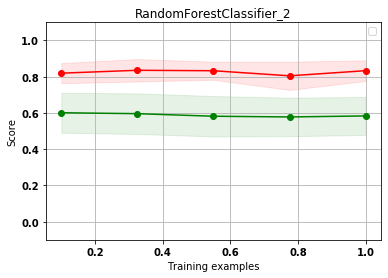

In [98]:

predict=rfc_cv_grid_2
train_sizes =np.linspace(.1, 1.0, 5)
cv =10
n_jobs=-1
verbose=0
classifier ='RandomForestClassifier_2'

plot = learning(predict, train_X, train_y,n_jobs, cv, train_sizes,verbose,classifier)

In [63]:
prediction_test_rf = pd.DataFrame(prediction_test_rf)
prediction_test_rf.to_csv('random_forest_model_un.csv')

# Logistic Regression

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import GridSearchCV
log_reg=LogisticRegression()

lr_grid = {'penalty' : ['l2'],
           'class_weight': ['balanced'],
            'C': [0.0001,0.01, 0.1,0.2,1],
           'max_iter':[100],
           'solver' : ['saga'],
          }
           
logreg_grid = GridSearchCV(log_reg, param_grid=lr_grid, cv=15)

logreg_grid.fit(train_X,train_y)


train_pred_lr=logreg_grid.predict(train_X)
test_pred_lr=logreg_grid.predict(test_X)
ac_test_pred_lr = logreg_grid.predict(test_data)

In [100]:
print(classification_report(train_y, train_pred_lr))
print(classification_report(test_y, test_pred_lr))

              precision    recall  f1-score   support

           0       0.29      0.53      0.38       500
           1       0.72      0.48      0.58      1229

    accuracy                           0.50      1729
   macro avg       0.51      0.51      0.48      1729
weighted avg       0.59      0.50      0.52      1729

              precision    recall  f1-score   support

           0       0.37      0.53      0.43       131
           1       0.75      0.60      0.67       302

    accuracy                           0.58       433
   macro avg       0.56      0.56      0.55       433
weighted avg       0.63      0.58      0.60       433



No handles with labels found to put in legend.


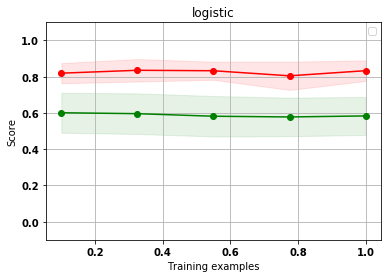

In [101]:
predict=logreg_grid
train_sizes =np.linspace(.1, 1.0, 5)
cv =10
n_jobs=-1
verbose=0
classifier ='logistic'

plot = learning(predict, train_X, train_y,n_jobs, cv, train_sizes,verbose,classifier)

In [70]:
print(ac_test_pred_lr)
prediction_test_rf = pd.DataFrame(ac_test_pred_lr)
prediction_test_rf.to_csv('logistic.csv')

[1 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 1
 0 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 0 1
 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1
 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 1 1
 0 0 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1
 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1
 1 1 0 1 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1
 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1
 0 1 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0
 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1
 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 0
 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1
 0 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0
 1 0 0 0 1 0 0 1 0 0 0 1 

# DecisionTree

In [102]:

from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.model_selection import GridSearchCV
param_grid={'criterion':['gini'],
           'min_samples_split':[2,4],
           'max_depth':[None,2,5],
           'min_samples_leaf':[1,2],
           'max_leaf_nodes':[None,5]}
df_1=tree.DecisionTreeClassifier()
clf_dt=GridSearchCV(df_1,param_grid,cv=5,n_jobs=-1)
clf_dt.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [None, 2, 5],
                         'max_leaf_nodes': [None, 5],
         

In [103]:
train_pred_dt = clf_dt.predict(train_X)

# predict the labels on validation dataset
val_pred_dt = clf_dt.predict(test_X)

test_pred_dt = clf_dt.predict(test_data)

No handles with labels found to put in legend.


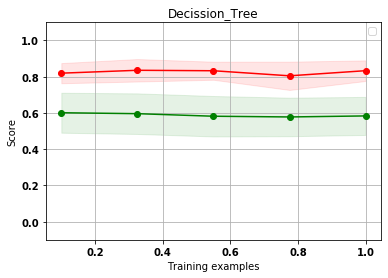

In [104]:
predict=clf_dt
train_sizes =np.linspace(.1, 1.0, 5)
cv =10
n_jobs=-1
verbose=0
classifier ='Decission_Tree'

plot = learning(predict, train_X, train_y,n_jobs, cv, train_sizes,verbose,classifier)

In [73]:
from sklearn.metrics import classification_report
print(classification_report(train_y, train_pred_dt))
print(classification_report(test_y, val_pred_dt))

              precision    recall  f1-score   support

           0       1.00      0.02      0.04       500
           1       0.71      1.00      0.83      1229

    accuracy                           0.72      1729
   macro avg       0.86      0.51      0.43      1729
weighted avg       0.80      0.72      0.60      1729

              precision    recall  f1-score   support

           0       0.75      0.02      0.04       131
           1       0.70      1.00      0.82       302

    accuracy                           0.70       433
   macro avg       0.73      0.51      0.43       433
weighted avg       0.72      0.70      0.59       433



#### Have reffered few Research Papers to get insights of data , like 
* https://airccj.org/CSCP/vol7/csit76615.pdf         
* https://arxiv.org/ftp/arxiv/papers/1603/1603.00751.pdf  
#### And few articles like 
* https://www.investopedia.com/articles/basics/10/efficiently-read-annual-report.asp
* https://nlp.stanford.edu/pubs/lrec2014-stock.pdf
#### Most Frequent words "Company","Million","Financial","Include" 
#### My Validation (zero F1+ One F1 / 2) Score is 0.55 , And my Test for same is 0.51 
#### EDA: 
* Have started reading some research papers how to predict long term stock .
* Figured out few section of data from 10k is important and fetch data from those sections Business operations, risk factors, selected ﬁnancial data, the Management's discussion and analysis (MD&A) and also Financial Statements and supplementary data
* We need to fetch data by WebScrapping data, using Beautiful soup and reading 10k document data .
* Using important section of  10k data and mapping each word to finance dictionary getting all  Negative , Positive , Uncertainty, Litigious,Constraining,Superfluous ,Interesting ,Modal ,Irr_Verb ,Harvard_IV ,Syllables features.
* Converting all features to percentage and then predict long term stock using ML.
* Tried to build multiple models using different algorithms.

